# GPS Notebook
This notebook gives an example of the EKF for GPS positioning. It reads the range and position of 4 satellites (provided in a toy dataset called "gps_data.csv") and uses the EKF to compute the position of the receiver. This repository is PYNQ-board agnostic, and has been tested on Pynq-Z1, Pynq-Z2 and Ultra96. 

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from ekf.gps_ekf import GPS_EKF, GPS_EKF_GENERAL

## 1. GPS Model
GPS is a satellite based navigation system that provides a user (or receiver) with accurate position information. It is based on the solving the following pseudorange equation:

$$\rho = \left\lVert X_{s} - X \right\rVert + b + v$$

where $X_{s}$ and $X$ represent the satellite and receiver positions, $\rho$ is the distance between satellite and receiver, $b$ is the clock bias of the receiver, and $v$ represents measurement noise. The aim is to find $X$ using measurements for $X_{s}$ and $\rho$. Given the presence of measurement noise and uncertainty, Kalman filtering methods are commonly deployed to solve this problem. In this particular case, $\rho$ is a non-linear equation and therefore the Extended Kalman Filter (EKF) is applied. An illustration of the model is given below. Here we assume there are 4 satellites, and the receiver is moving linearly (i.e. with constant velocity).

<img src="./imgs/gps_model.png" alt="Drawing" width="600"/>

## 2. Load Dataset
Lets load the toy dataset and visualise the measurements for $X_{s}$ and $\rho$. We have a total of 4 satellites, each having a position given by an (x, y, z) co-ordinate, and distance to receiver given by $\rho$. This gives a total of 16 measurements. Our aim is to use these measurements to estimate the position of the receiver, assuming the receiver is moving linearly (i.e. with constant velocity).

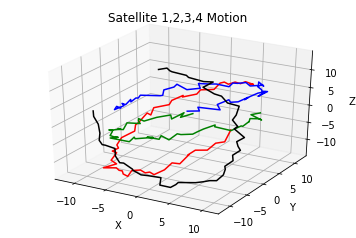

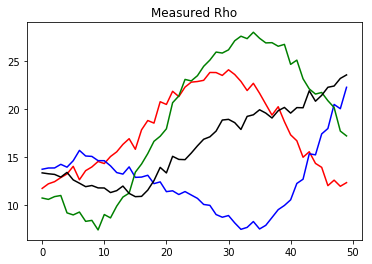

In [2]:
data = np.loadtxt("gps_data.csv", delimiter=",", skiprows=1)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_title("Satellite 1,2,3,4 Motion")
ax.plot(data[:, 0], data[:, 1], data[:, 2], "r")
ax.plot(data[:, 3], data[:, 4], data[:, 5], "b")
ax.plot(data[:, 6], data[:, 7], data[:, 8], "g")
ax.plot(data[:, 9], data[:, 10], data[:, 11], "k")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_axis_off

plt.show()

fig = plt.figure()
ax = fig.gca()
ax.set_title("Measured Rho")
x = np.arange(len(data))
ax.plot(x, data[:, 12], "r") 
ax.plot(x, data[:, 13], "b") 
ax.plot(x, data[:, 14], "g") 
ax.plot(x, data[:, 15], "k") 

plt.show()

## 3. EKF Model

#### 1. State and Input Variables:

| Variable  | Notation  | Length | Description  |
|---|---|---|
| state  | x  | 8 | state vector, consisting of rx position, velocity, clock bias, clock drift |
| inputs  | $X_{s}$ | 12 | measured satellite positions using cartesian co-ordiantes  |
| measurements  | $\rho$  | 4 | measured distance between receiver and satellite  |


#### 2. Process Model:
The state transition function (or process model), $f$, is a linear equation with additive noise $\sigma=N(0, Q)$. This is because the receiver is assumed to be moving with constant velocity. We use this function to estimate the next state, given a current estimate for the state.
    
$$ x_{t} = f(x_{t-1}) = A x_{t-1} + \sigma$$ 


#### 3. Observation Model
The observation equation uses the pseudorange equation, with noise $v=N(0, R)$, to relate the state vector to our measurements. Here, $X$ is the receiver position (in 3D cartesian co-ordinates), which is estimated by $x[0]$, $x[2]$ and $x[4]$ in the state vector.

$$\rho = h(x_{t}) = \left\lVert X_{s} - X \right\rVert + b + v$$



#### 2. Initialisation:

EKF's can diverge quickly if they are not initialised properly. By default, our GPS_EKF class initialises the state so that it's position and velocity are close to the first data point in gps_data.csv. We chose to use simple covariance models in this example. This corresponds to identity matrices scaled by **qval**, **rval** and **pval** for the process covariance **Q**, observation covariance **R** and estimated state covariance **P** respectively. The ratio **qval/rval** is very important and indicates the relative weight which is applied to our estimation model.

## 4. FPGA Accelerator

### 4.1 Hardware-Software:

The HW-SW design only offloads the application-independent part of the algorithm to the FPGA. The application specific parts, such as the **process model (f)** and **observation model (h)** are implemented in software.

<img src="./imgs/hwsw.png" alt="Drawing" width="500"/>

First instantiate an EKF with **n=8** states and **m=4** observations:

In [3]:
ekf = GPS_EKF_GENERAL(8, 4, qval=0.1, rval=20.0, pval=0.5)
res_sw = ekf.run_sw(data)
res_hw = ekf.run_hw(data)
print("Equal: ", np.allclose(res_sw, ekf.toFloat(res_hw), rtol=1e-2))

Equal:  True


If we would like to reset and run the hardware again:

In [4]:
ekf.reset()
res_hw = ekf.run_hw(data)

Lets check the performance of this implementation:

In [5]:
import timeit
number=20
ekf.reset()

def hwresp():
    y=ekf.run_hw(data)
    return

hw_time = timeit.timeit(hwresp, number=number)

def swresp():
    y=ekf.run_sw(data)
    return

sw_time = timeit.timeit(swresp,number=number)

print("Time taken by software", number,"times",sw_time)
print("Time taken by hardware", number,"times",hw_time)
print("HW Speedup = %.2fx"%(sw_time/hw_time))

Time taken by software 20 times 1.1674757859436795
Time taken by hardware 20 times 130.70622718695085
HW Speedup = 0.01x


Plot the position of the receiver, and reset all CMA buffers:

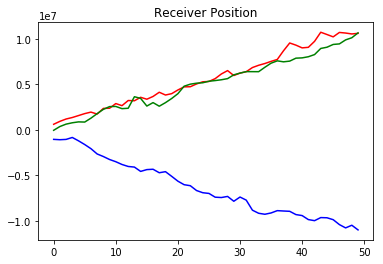

In [6]:
plt.figure()
plt.title("Receiver Position")
x = np.arange(len(res_hw))
plt.plot(x, res_hw[:, 0], "r")
plt.plot(x, res_hw[:, 1], "b") 
plt.plot(x, res_hw[:, 2], "g") 
plt.show()

ekf.xlnk.xlnk_reset()

### 4.2 Hardware-Only

Alternatively, the entire algorithm can be deployed on the FPGA. This requires a custom HLS design for computing the process and observation functions, as well as Jacobian matrices. 

In [7]:
ekf = GPS_EKF(8, 4, qval=0.1, rval=20.0, pval=0.5)
res_sw = ekf.run_sw(data)

Next we run in hardware. This time run_hw() takes fixed point data as input. We instantiate

In [10]:
from rig.type_casts import NumpyFloatToFixConverter, NumpyFixToFloatConverter
toFixed = NumpyFloatToFixConverter(signed=True, n_bits=32, n_frac=20)
toFloat = NumpyFixToFloatConverter(20)

data_hw = toFixed(data)
data_hw = ekf.copy_array(data_hw)
ekf = ekf.configure()
res_hw = ekf.run_hw(data_hw)
res_hw = toFloat(res_hw)
print("Equal: ", np.allclose(res_sw, res_hw, rtol=1e-2))

Equal:  True


Plot the position of the receiver:

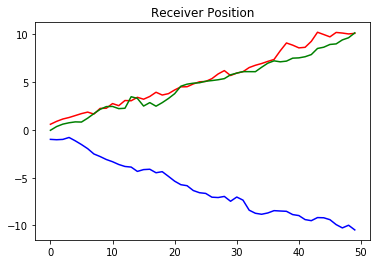

In [11]:
plt.figure()
plt.title("Receiver Position")

x = np.arange(len(res_hw))

plt.plot(x, res_hw[:, 0], "r")
plt.plot(x, res_hw[:, 1], "b") 
plt.plot(x, res_hw[:, 2], "g") 
plt.show()

Now lets check the performance. It should be significantly faster than HW-SW and SW-only.

In [12]:
import timeit
number=20

def hwresp():
    y=ekf.run_hw(data_hw)
    return

hw_time = timeit.timeit(hwresp,number=number)

def swresp():
    y=ekf.run_sw(data)
    return

sw_time = timeit.timeit(swresp,number=number)

print("Time taken by software", number,"times",sw_time)
print("Time taken by hardware", number,"times",hw_time)
print("HW Speedup = %.2fx"%(sw_time/hw_time))

Time taken by software 200 times 18.28879288607277
Time taken by hardware 200 times 0.4091668860055506
HW Speedup = 44.70x


In [13]:
ekf.xlnk.xlnk_reset()